---


# Rechnernutzung in der Physik
**Institut für Experimentelle Teilchenphysik**  
Prof. G. Quast, Dr. Th. Chwalek  
WS 2024/25 – Blatt 06

Abgabe: Mo./Di. 27./28. Januar bzw. Mo./Di. 03./04. Februar  

---

Auf diesem letzten Übungsblatt sollen viele der Konzepte und Techniken aus dem Block angewendet und
vertieft werden. In dieser Projektaufgabe sollen mit Hilfe eines Ensemble-Tests aus vielen Pseudoexperimenten (auch: Toy-MC) die Eigenschaften einer (einfachen) Parameteranpassung an einem realitätsnahen Beispiel untersucht werden. Dabei erwarten wir, dass Sie aus den Beispielen in Vorlesung und Tutorium sowie aus den weiteren hier angegebenen Tutorials und aus der Online-Dokumentation der verwendeten Software-Werkzeuge eigenständig Elemente zur Lösung der Aufgaben zusammenstellen.

Das Blatt darf innerhalb einer Tutoriumsgruppe zu maximal dritt bearbeitet werden. Die Abfrage erfolgt jedoch gleichmäßig. Jede teilnehmende Person muss in der Lage sein jeden Programmschritt vollständig erklären zu können.
**Anmerkung:** die Bearbeitung dieses Blattes ist **verpflichtend** für den Erhalt des Übungsscheins.

---
# Projektaufgabe "Ensemble-Test"
---

Gemessen werden soll die Lebensdauern von Teilchen, die nach Durchgang durch einen Detektor in einem Absorber gestoppt werden. Die Zerfälle werden über die Zerfallsprodukte wieder vom selben Detektor registriert. Die theoretische Lebensdauer der Teilchen beträgt $\tau=$2µs, dies entspricht in etwa der Lebensdauer des Myons. Wegen der Überlappung der Detektorsignale können Lebensdauern kleiner als $t_{\rm min}=$1µs nicht zuverlässig gemessen werden. Die Messelektronik ist nur bis zum Zeitpunkt $t_{\rm max}=$10µs aktiv. Die Zahl der so registrierten Zerfälle ist mit $N=50$ registrierten Ereignissen nur sehr klein, so dass in einem ungebinner Maximum-Likelihood-Fit (d.h. alle Datenpunkte werden in der Likelihood-Funktion berücksichtigt, nicht nur die Einträge in Bins eines Histogramms) eine Exponentialfunktion an die im Intervall $[t_{\rm min}, t_{\rm max}]$ gemessenen Lebensdauern angepasst werden soll.

Es stellen sich zwei Fragen:
1. Ist der Schätzwert für die Lebensdauer $\hat{\tau}$ *erwartungstreu* (auch: unverzerrt, engl.: unbiased)? 
2. Wie gut ist die *Abdeckung* (engl.: coverage) des Konfidenzintervalls für $\hat{\tau}$?

**Zur Erläuterung:** Die Unsicherheit auf die gemessene Lebensdauer soll aus einem Scan der negativen Log-Likelihood (NLL) gewonnen werden. Das Intervall $[\hat{\tau}-\Delta^-, \hat{\tau}+\Delta^+]$ mit den asymmetrischen Unsicherheiten $\Delta^+$ und $\Delta^-$ heißt Konfidenzintervall. Zur Erinnerung: in der frequentistischen Statistik liegt der wahre Wert eines Parameters in einem Bruchteil $\alpha$ aller aus Daten konstruierten Konfidenzintervalle. Eine häufige Wahl ist $\alpha\approx 0,683$, dies entspricht einer Standardabweichung der Gaußverteilung. Ein wichtiger Test bei der Bestimmung von Konfidenzintervallen mithilfe von Ensemble-Tests ist die Überprüfung der Abdeckung, also die Frage, ob der wahre Wert wirklich in in einem Bruchteil $\alpha$ aller Konfidenzintervalle liegt.

**Hinweise:** Lesen Sie alle Aufgaben zuerst durch, planen Sie die Programmstruktur sorgfältig und achten Sie auf einen modularen Aufbau der einzelen Teile, damit Sie die notwendigen Schritte in einer Schleife ausführen und die gesamte Studien ggf. mit unterschiedlichen Parametereinstellungen wiederholen können. In den Codebeispielen zur Vorlesung finden Sie eine Reihe von Lösungsansätzen,
insbesondere im Jupyter-Tutorial *negLogLFits.ipynb*.


In [1]:
# notwendige Importe: numpy, matplotlib.pyplot, Fit Pakete
import numpy as np
import matplotlib.pyplot as plt

# ->  eigenen Code hier einfügen
from kafe2.fit import UnbinnedContainer, Fit, Plot
from kafe2.fit.tools import ContoursProfiler

## Aufgaben

(1) Schreiben Sie eine Funktion, die 50 exponentiell verteilte Zufallszahlen im sensitiven Detektorintervall $[t_{\rm min}, t_{\rm max}]$ erzeugt.

In [2]:
# Parameter für die Ausführung der Studie als globale Variable
Nexp = 3000
N = 50
tau = 2.0
tmin = 1.0
tmax = 10.0

npar = 1  # Zahl der angepassten Parameter
pnams = ["tau"]  # Liste mit Namen der Parameter
true_vals = np.array([tau, tmin, tmax])  # die "Wahren Werte"

In [3]:
# definieren Sie hier die Verteilungsdichte g
def exponentialDecayPDF(t, tau= tau, tmin=tmin, tmax=tmax):
    #Normiere PDF auf Intervall [tmin, tmax]
    c_norm = 1/(np.exp(-tmin/tau)-np.exp(-tmax/tau))
    return c_norm * 1/tau *np.exp(-t/tau)

#G
def G(t, tau):
    return 1-np.exp(-t/tau)

# G^(-1)
def t(r, tau):
    return -tau*np.log(1-r)


In [4]:
# Funktion zur Erzeugung der Daten
def generateExpData(N, tau, tmin, tmax):
    r_max = G(tmax, tau)
    r_min = G(tmin, tau)
    
    r = np.random.uniform(low=r_min, high=r_max, size=N)
    return t(r,tau)

#print(x)
#print(exponentialDecayPDF(x))

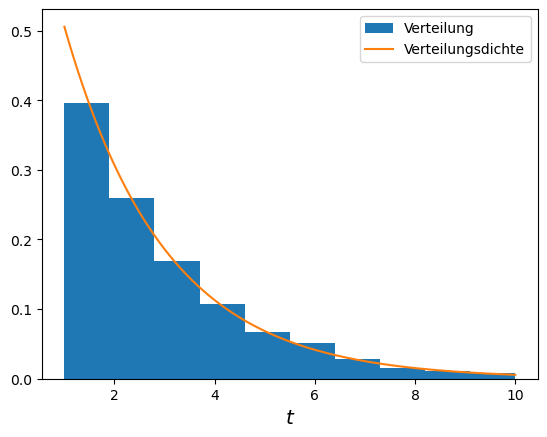

In [5]:
# plot, für 100-faches N
plt.hist(generateExpData(N*100,tau,tmin,tmax), bins = 10, density = True, label = 'Verteilung')

#Darstellung PDF
x = np.linspace(tmin,tmax,500)
plt.plot(x, exponentialDecayPDF(x,tau,tmin,tmax), '-', label = 'Verteilungsdichte')

# make plot nice
plt.xlabel('$t$', fontsize='x-large')
#plt.ylabel('$g(t(r))$')
plt.legend(loc='upper right')

plt.show()

(2) Setzen Sie eine Anpassung mit einer ungebinnten negativen log-Likelihood-Funktion auf.
   Dazu können Sie das Beispiel aus der Vorlesung und aus einem früheren Übungsblatt nutzen.
   Wenn Sie die Maximum-Likelihood-Anpassung nicht selbst programmieren möchten, können Sie
   entsprechenden Methoden in *kafe2* (*UnbinnedContainer*) oder die Funktion
   *PhyPraKit.phyFit.mFit()* dazu verwenden, die in der
   [PhyPraKit-Dokumentation](https://etpwww.etp.kit.edu/~quast/PhyPraKit/htmldoc/)
   beschrieben ist.

In [6]:
def unbinned_fit_exp(t, tmin, tmax, show_plot = False):
    data = UnbinnedContainer(t)  # create the kafe data object
    
    # create the fit object and set the pdf for the fit
    fit = Fit(data=data, model_function=exponentialDecayPDF)
    #fix parameters
    fit.fix_parameter("tmin", tmin)
    fit.fix_parameter("tmax", tmax)
    
    fit.do_fit(asymmetric_parameter_errors=True)  # perform the fit

    if show_plot:
        fit.report(asymmetric_parameter_errors=True)  # print a fit report to the terminal

        plot = Plot(fit)  # create a plot object
        plot.plot(fit_info=True, asymmetric_parameter_errors=True)  # plot the data and the fit
        plot.show()  # show the plot(s)
        
    tau = fit.parameter_values[0]
    tau_errs = fit.asymmetric_parameter_errors[0]
    #print(tau, tau_errs)
    return tau, tau_errs[0], tau_errs[1]
    

#########
# Model #
#########

    Model Function

        exponentialDecayPDF(t; tau, tmin, tmax)

###############
# Fit Results #
###############

    Model Parameters

        tau = 2.78 + 0.64 (up) - 0.45 (down)
        tmin = 1 (fixed)
        tmax = 10 (fixed)

    Model Parameter Correlations

              tau  tmin  tmax
              ===  ====  ====
        tau   1.0  0.0   0.0 
        tmin  0.0  0.0   0.0 
        tmax  0.0  0.0   0.0 

    Cost Function

        Cost function: negative log-likelihood

        Cost = 185.1



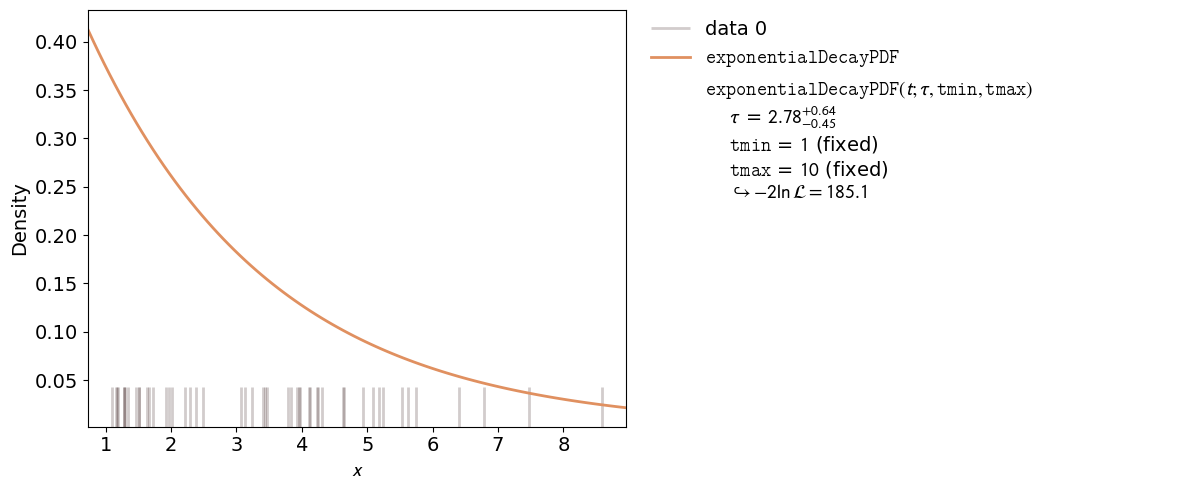

(np.float64(2.7825804920063146),
 np.float64(-0.4523815541225992),
 np.float64(0.6357851380298133))

In [7]:
#Testlauf
dt = generateExpData(N,tau,tmin,tmax)
unbinned_fit_exp(dt, tmin, tmax, show_plot=True)

In [8]:
# Schleife zur wiederholten Ausführung von Datenerzeugung, Anpassung und zum Speichern der Ergebnisse
def MC_loop(N_exp):
    """
    Returns:

    Numpy Array
        Array der Form [tau, del_tau_minus, delta_tau_plus]
    """

    
    #Erzeuge Array mit N_exp mal 3 Einträgen
    results = np.zeros((N_exp,3))
    for i in range(N_exp):
        dt = generateExpData(N,tau,tmin,tmax)
        results[i] = unbinned_fit_exp(dt, tmin, tmax) #Fit und Abspeichern
    return results
    

(3) Führen Sie (1) und (2) in einer Schleife aus; das Ziel ist es, 3000 Pseudoexperimente zu simulieren. Beginnen Sie zum Testen des Codes aber zunächst mit einer kleineren Anzahl! Denken Sie daran, in der Schleife die zur Bestimmung von Erwartungstreue und Abdeckung notwendigen Daten in einem Array zu speichern. 

In [9]:
# run MC loop
N_exp = 3000
tau_results = MC_loop(N_exp)
print(tau_results)

/opt/conda/lib/python3.11/site-packages/kafe2/fit/unbinned/cost.py:35: RuntimeWarning: divide by zero encountered in log
  _total_log_likelihood = np.sum(np.log(model))


/tmp/ipykernel_98/3154161982.py:4: RuntimeWarning: overflow encountered in exp
  c_norm = 1/(np.exp(-tmin/tau)-np.exp(-tmax/tau))
/tmp/ipykernel_98/3154161982.py:5: RuntimeWarning: overflow encountered in exp
  return c_norm * 1/tau *np.exp(-t/tau)
/tmp/ipykernel_98/3154161982.py:5: RuntimeWarning: invalid value encountered in multiply
  return c_norm * 1/tau *np.exp(-t/tau)
/opt/conda/lib/python3.11/site-packages/kafe2/fit/unbinned/cost.py:35: RuntimeWarning: divide by zero encountered in log
  _total_log_likelihood = np.sum(np.log(model))


/tmp/ipykernel_98/3154161982.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  c_norm = 1/(np.exp(-tmin/tau)-np.exp(-tmax/tau))
/tmp/ipykernel_98/3154161982.py:5: RuntimeWarning: invalid value encountered in multiply
  return c_norm * 1/tau *np.exp(-t/tau)


[[ 2.30135244 -0.34586893  0.46075664]
 [ 2.37940568 -0.3625343   0.48636279]
 [ 1.75725624 -0.24251712  0.30759395]
 ...
 [ 1.43909501 -0.19149922  0.23692233]
 [ 2.29150635 -0.34382728  0.45756717]
 [ 2.03486532 -0.29261861  0.38024033]]


(4) Analysieren Sie die in der Monte Carlo-Schleife gewonnenen Daten und geben Sie Erwartungstreue und Abdeckung für die geschätzte Lebensdauer $\hat{\tau}$ und deren Unsicherheitsintervall $[\hat{\tau}-\Delta^-, \hat{\tau}+\Delta^+]$ an. Denken Sie daran, dass Sie auch die statistische Signifikanz der so bestimmten Eigenschaften sicherstellen müssen. Schätzen Sie daher die Unsicherheiten der ermittelten Erwartungstreue und Abdeckung ab. 

In [20]:
# Berechnung und Ausgabe der Ergebnisse

#Erwartungswert / Mittelwert von Tau
tau_mean = np.mean(tau_results[:,0])
#Fehlerberechnung nach Gauss: Wurzel(1/N^2 * sum(sigma^2))
tau_uncert = np.zeros(2)
tau_uncert[0] = -np.sqrt(1/len(tau_results)**2 * np.sum(tau_results[:,1]**2) )
tau_uncert[1] = np.sqrt(1/len(tau_results)**2 * np.sum(tau_results[:,2]**2) )

print(f"Erwartungswert von Tau: {tau_mean:.4f} +{tau_uncert[1]:.4f} {tau_uncert[0]:.4f}")

#Erwartungstreue
b = tau_mean - tau

print(f"Erwartungstreue von Tau: {b:.4f} +{tau_uncert[1]:.4f} {tau_uncert[0]:.4f}")

#Abdeckung
count = 0
for i in range(len(tau_results)):
    if tau_results[i][0] + tau_results[i][1] <= tau and tau <= tau_results[i][0] + tau_results[i][2]:
        count +=1

coverage = count/len(tau_results)
#Fehler: Zwei Mögliche Ausgänge -> Binomialverteilung
coverage_uncert = np.sqrt(coverage*(1-coverage)/len(tau_results))

print(f"Abdeckung: {coverage:.4f} +-{coverage_uncert:.4f}")

Erwartungswert von Tau: 2.0079 +0.0072 -0.0055
Erwartungstreue von Tau: 0.0079 +0.0072 -0.0055
Abdeckung: 0.6860 +-0.0085


(5) Bewerten Sie Ihre Ergebnisse:   
    a) Wird eine statistisch signifikante Verzerrung nachgewiesen?   
    b) Ist sie ggf. im Bezug auf die Unsicherheiten der Einzelmessungen relevant?  
    c) Benötigen Sie auf Grund der festgestellten Unter- oder Überabdeckung eine Korrektur des für eine Einzelmessung relevanten Konfidenzintervalls ? 

##### Antworten

Nein, Verzerrung ist in der gleichen Größenordnung wie die ihre Unsicherheit. Die Abdeckung ist ebenfall sehr zufriedenstellend.

(6) **Freiwillig**: In der Vorlesung haben Sie die "Bootstrap-Methode" kennen gelernt, um die Eigenschaften von Funtionen von Zufallszahlen zu untersuchen. Diese Methode lässt sich auch auf das hier behandelte Problem anwenden. Schreiben sie dazu eine Funktion, die aus einem einzigen initialen, mit der unter 1) geschriebenen Funktion erzeugten Daten neue Datensätze durch "Ziehen mit Zurücklegen" erzeugt. Dazu können Sie die Methode `rng.choice(data, size=N)` verwenden. Führen Sie nun wiederum die Schritte 2) - 4) durch und vergeleichen Sie das Ergebnis. Sie sollten diese Studie mit mehreren verschiedenen initialen Datensätzen wiederholen, da im Einzelfall, abhängig vom initialen Datensatz, größere Fluktuationen auftreten.

In [ ]:
# Funktion zum Re-Sampling der Daten (für Bootstrap)
# def resampleData(N, dT0):



In [ ]:
# Einen Datensatz erzeugen
# run MC loop

# Daten mit Resampling ("bootstrapping")
